In [65]:
import cv2
from PIL import Image
import numpy as np
import os
print(os.listdir('./imgs'))

['.DS_Store', '62x_Salac_Pa14wt_SaPa14wt=1-1,1-10,100-1,10-1_co_SCFM2_tile2x2_3-13-19_z17_t09_p5_m2.tif', '62x_Salac_Pa14wt_SaPa14wt1-11-10100-110-1_co_SCFM2_tile2x2_4-17-19_z19_t01_p3_m3.tif']


In [66]:
slices = 2
for img_path in os.listdir('./imgs'):
    if img_path == '.DS_Store':
        continue
    img = cv2.imread(os.path.join('./imgs', img_path))
    original_size = img.shape[0]
    edge = original_size // slices
    num = original_size / edge + 1
    
    count = 1
    for x in range(slices):
        for y in range(slices):
            sub_img = img[x*edge:x*edge+edge,y*edge:y*edge+edge,:]
            cv2.imwrite(os.path.join('./train', img_path)+'-{}.jpg'.format(count), sub_img) 
            count += 1

Lossy conversion from float64 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


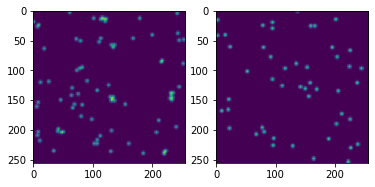

Lossy conversion from float64 to uint8. Range [0.0, 7.490483983255796]. Convert image to uint8 prior to saving to suppress this warning.


In [45]:
import json
import cv2
import collections
import numpy as np
import matplotlib.pyplot as plt
import imageio
import scipy.ndimage as ndimage
%matplotlib inline

filename = 'train_imgs/62x_Salac_Pa14wt_SaPa14wt1-11-10100-110-1_co_SCFM2_tile2x2_4-17-19_z19_t01_p3_m3.tif-1'
with open(filename+'.json', 'r') as f:
    a = json.load(f)

cache = collections.defaultdict(list)
for item in a["shapes"]:
    point = item['points'][0]
    cache[item['label']].append(point)

img = cv2.imread(filename+'.jpg')
size = img.shape[0]
label = np.zeros((size, size, 3))


X = []
Y = []
for (y, x) in cache['red']:
    label[int(x)][int(y)][0] = 255.0
    X.append(int(x))
    Y.append(int(y))
for (y, x) in cache['green']:
    label[int(x)][int(y)][1] = 255.0
    
imageio.imwrite('label.png', label)

# Gaussian Kernel
red = 100.0 * (label[:,:,0] > 0)
red = ndimage.gaussian_filter(red, sigma=(2, 2), order=0)
green = 100.0 * (label[:,:,1] > 0)
green = ndimage.gaussian_filter(green, sigma=(2, 2), order=0)

plt.subplot(1,2,1)
plt.imshow(red)
plt.subplot(1,2,2)
plt.imshow(green)
plt.show()

label[:,:,0] = red
label[:,:,1] = green

imageio.imwrite('density_map.png', label)

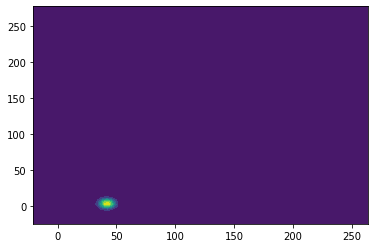

In [64]:
from scipy.stats import multivariate_normal
x = X
y = Y
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
pos = np.dstack((xx, yy))
rv = multivariate_normal([42, 3], [[20.0, 0], [0, 20.0]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(xx, yy, rv.pdf(pos))